In [1]:
%matplotlib inline

from xgboost.sklearn import XGBClassifier
from typing import Tuple
import xgboost as xgb
import pandas as pd
import json
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

/Users/suchismitapadhy/anaconda3/envs/MRenv/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
dataset = pd.read_csv('data/multisession-eeg.csv')
fromstring = lambda array_str: np.fromstring(array_str, dtype=float, sep=',')
dataset.raw_fft = dataset.raw_fft.apply(fromstring)
# dataset.raw_fft.iloc[0]

# Passthoughts

What if you could simply *think your password*? That's the premise behind *passthoughts*. We'll discuss passthoughts in more depth in lecture 3, but for now, we'll lay this out as a classification problem:

> Given a reading, and a person, is that person who they claim to be?

We'll structure this problem as follows: For each subject, we'll train a classifier. That subject's readings will be positive example, and everyone else's readings will be negative examples.

We can make this a little fancier by having people use specific thoughts (e.g. "focus on your breathing," "sing a song in your head," etc). We'll make sure our methods can handle this case, but for the time being, we'll just use the `"unabeled"` readings - people doing nothing in particular.

We'll use subject `A` as our "target" individual. We will train on this subject for this assignment, and train against the other subjects in the corpus (subjects `B` and `C`).

In [3]:
def to_matrix (series):
    return np.array([ x for x in series ])

def readings_right_subject_right_task (subj, task, session=0):
    return to_matrix(dataset[
        (dataset['subject'] == subj) &
        (dataset['label'] == task) &
        (dataset['session'] == session)
    ].raw_fft)

def readings_wrong_subj_any_task (subj):
    return to_matrix(dataset[
        (dataset['subject'] != subj)
    ].raw_fft)

In [4]:
#dataset[(dataset.subject == 'A') &  (dataset.label == 'unlabeled')].raw_fft.apply(lambda x:x.shape)
#['A', 'unlabeled']
# dataset

In [5]:
dataset['label'].unique()

array(['unlabeled', 'breathe', 'song', 'song_o', 'sport', 'breathe_o',
       'speech', 'face', 'calibration', 'word_x', 'phrase_x', 'face_x',
       'breatheopen', 'song_x', 'sport_x', 'breatheclosed', 'word_c',
       'phrase_c', 'face_c', 'song_c', 'sport_c'], dtype=object)

In [6]:
positive = readings_right_subject_right_task('A', 'unlabeled', 0)
negative = readings_wrong_subj_any_task('A')
positive.shape, positive.shape

((40, 516), (40, 516))

## TODO

Notice how we structured our positive and negative examples:

- *Positive examples*: The right person thinking the right task.

- *Negative examples*: The wrong person thinking any task (whether it is right or wrong).

In the context of passthoughts, consider other possibilites for selecting positive and negative features. Here, (1) pick one configuration of positive and negative examples, aside from the ones listed, and (2) discuss their possible consequences (pros/cons). Explain how you might evaluate this selection (with data, with user experiments, etc - your choice).

*Your answer here...*
-----
- *Positive examples*: The right person thinking any task.
- *Negative examples*: The wrong person thinking any task (whether it is right or wrong).

In [7]:
def to_matrix_new (series):
    return np.array([ x for x in series ])

def readings_right_subject_right_task_new (subj, session=0):
    return to_matrix_new(dataset[
        (dataset['subject'] == subj) &
        (dataset['session'] == session)
    ].raw_fft)

def readings_wrong_subj_any_task_new (subj):
    return to_matrix_new(dataset[
        (dataset['subject'] != subj)
    ].raw_fft)

In [8]:
positive_new = readings_right_subject_right_task_new('A', 0)
negative_new = readings_wrong_subj_any_task_new('A')
positive_new.shape, positive_new.shape

((222, 516), (222, 516))

Now, we'll turn these data into our feature/label matrices `X` and `y`.

In [9]:
X = np.concatenate([positive, negative])

In [10]:
y = np.array([ 0 for x in positive] + [ 1 for x in negative])
assert X.shape[0] == y.shape[0]

Note that we are assigning `0` to "positive" examples, and `1` to "negative" examples. That means `0` will mean "ACCEPT" and `1` will mean "REJECT."

## TODO

Now, train and test a classifier! Estimate your classifier's accuracy.

In [11]:
# Your code here....

#logistic regression

def fresh_clf () -> XGBClassifier:
    return XGBClassifier(
        # Don't worry about those parameters for now,
        # though feel free to look them up if you're interested.
        objective= 'binary:logistic',
        seed=27)

def xgb_cross_validate (
    X: np.array,
    y: np.array,
    nfold: int=7
) -> Tuple[XGBClassifier, pd.DataFrame]:
    # eval_metrics:
    # http://xgboost.readthedocs.io/en/latest//parameter.html
    metrics = ['error@0.1', 'auc']
#     metrics = [ 'auc' ]
    # we use the @ syntax to override the default of 0.5 as the threshold for 0 / 1 classification
    # the intent here to to minimize FAR at the expense of FRR
    alg = fresh_clf()
    xgtrain = xgb.DMatrix(X,y)
    param = alg.get_xgb_params()
    cvresults = xgb.cv(param,
                      xgtrain,
                      num_boost_round=alg.get_params()['n_estimators'],
                      nfold=nfold,
                      metrics=metrics,
                      early_stopping_rounds=100
                      )
    alg.set_params(n_estimators=cvresults.shape[0])
    alg.fit(X,y,eval_metric=metrics)
    return alg, cvresults

In [12]:
X_train, X_validate, y_train, y_validate = train_test_split(
    X, y, 
    test_size=0.33, 
    random_state=42)

clf, cvres = xgb_cross_validate(X_train, y_train)

In [13]:
clf.score(X_validate, y_validate)

0.98329355608591884

For authentication, what we want even more than "accuracy" here are two metrics:

- False Acceptance Rate (FAR): The percentage of readings *not* from subject A incorrectly classified "ACCEPT."
- False Rejection Rate (FRR): The percentage of readings *from* subject A incorrectly classified 'REJECT."

For authentication /security/, we want FAR to be as low as possible (so nobody can break in).
For authentication /usability/, we want FRR to be low (so user's don't get frustrated constantly re-trying their passthought).

In [15]:
def far_frr (classifier, features, labels):
    # predict all the labels
    y_pred = classifier.predict(features)
    false_accepts = 0
    false_rejects = 0
    for predicted, actual in zip(y_pred, labels):
        # if we should have rejected,
        # but in fact accepted,
        if (actual == 1) and (predicted == 0):
            # increment false accepts
            false_accepts += 1
        # if we should have accepted,
        # but in fact rejected,
        if (actual == 0) and (predicted == 1):
            # increment false rejections
            false_rejects += 1
    # calculate proportions for each
    far = false_accepts / len(list(filter(lambda x: x==0, y_pred)))
    frr = false_rejects / len(list(filter(lambda x: x==1, y_pred)))
    return far, frr

In [16]:
far, frr = far_frr(clf, X_validate, y_validate)
f'FAR: {far} - FRR: {frr}'

'FAR: 0.3 - FRR: 0.009779951100244499'

Now, these results might be good. 

But our classifier's accuracy could be misleading.   

Can you see why? 

# Nonstationarity

We are training, and testing, using data recorded over a single session. As we know, EEG changes over time, a property known as *nonstationarity*. Will our great results still hold a few weeks later?

Let's take subject `A`'s data from sessions 1 and 2, which were recorded a few weeks after session 0.

In [17]:
# X_subja_sess1 = readings_right_subject_right_task('B', 'unlabeled', 1)
# X_subja_sess2 = readings_right_subject_right_task('B', 'unlabeled', 2)
# X_subja_later = np.concatenate([X_subja_sess1, X_subja_sess2])
# y_subja_later = [ 1 for x in X_subja_later ]

#### Our classifier is trained on A, session 0 as positive examples. And for B,C, session 0 as negative examples.
#### In the following cell we test this classifier with A but session 1 and 2

In [18]:
X_subja_sess1 = readings_right_subject_right_task_new('A', 1)
X_subja_sess2 = readings_right_subject_right_task_new('A', 2)

y_subja_sess1 = [ 1 for x in X_subja_sess1 ]
y_subja_sess2 = [ 1 for x in X_subja_sess2 ]
# X_subjb_sess0 = readings_right_subject_right_task_new('B', 0)
# X_subjc_sess0 = readings_right_subject_right_task_new('C', 0)

X_subja_later = np.concatenate([X_subja_sess1, X_subja_sess2])

y_subja_later = [ 1 for x in X_subja_later ]


# X_subjbc_later = np.concatenate([X_subjb_sess0, X_subjc_sess0])
# y_subjbc_later = [ 0 for x in X_subjbc_later ]

# X_subjects = np.concatenate([X_subja_later, X_subjbc_later])
# y_subjects = np.concatenate([y_subja_later,y_subjbc_later])

Now, let's try the classifier we trained on the original data, testing it on the later data.

In [19]:
print("classifier score with test sets from sessions 1 and 2 :",clf.score(X_subja_later, y_subja_later))

classifier score with test sets from sessions 1 and 2 : 0.776691729323


In [20]:
print("classifier score with test sets from only session 1 :",clf.score(X_subja_sess1, y_subja_sess1))

classifier score with test sets from only session 1 : 1.0


In [21]:
print("classifier score with test sets from only session 2 :",clf.score(X_subja_sess2, y_subja_sess2))

classifier score with test sets from only session 2 : 0.677524429967


### The results above suggests that the values for session 2 are not in sync with the other 2 sessions. This can be due to some calibration issue.

As we will discuss more in lecture 3, this is a problem for us. After all, we can calibrate our target subject, but we then expect them to leave the lab and go use the device later on. If their state changes so much that they can no longer be authenticated, we can't very well claim our system is accurate!

## TODO

The crux of the lab focuses on nonstationarity. At minimum, your mission is to quantify and qualify *what* is changing in EEG signals over time. You may use any tools in answering this question.

You also have your choice of corpus:

- Study subject `A`'s recordings over the three sessions provided here.
- Study one subject's recordings over the course of a year.

You can use both of these corpora, if you would like.

Some questions to spur investigation:

- What features of readings cause a classifier that works on earlier recordings fail on later ones?
- What features remain the same? Are there any?
- What might be the source of these changing features? Changing placement in the EEG device? Changing properties of the brain?

Please note below all work you do, and any notes you make along the way. Ideally, your work should read like a story - words (and questions!) interspersed with code. Good luck, and have fun!

In [22]:
X_subja_sess0 = readings_right_subject_right_task_new('A', 0)
X_subja_sess1 = readings_right_subject_right_task_new('A', 1)
X_subja_sess2 = readings_right_subject_right_task_new('A', 2)

In [23]:
subject_A = np.concatenate([X_subja_sess0, X_subja_sess1, X_subja_sess2])

In [24]:
tasks = dataset['label'].unique().tolist()

In [41]:
tasks_0 = set(dataset[(dataset.session == 0)].label.unique().tolist())
tasks_1 = set(dataset[(dataset.session == 1)].label.unique().tolist())
tasks_2 = set(dataset[(dataset.session == 2)].label.unique().tolist())
print("Tasks in Session 0: \n", tasks_0, "\n")
print("Tasks in Session 1: \n", tasks_1, "\n")
print("Tasks in Session 2: \n", tasks_2, "\n")
tasks_common = list(tasks_0.intersection(tasks_1).intersection(tasks_2))

print("Common Tasks Across Sessions: \n", tasks_common, "\n")

Tasks in Session 0: 
 {'face_c', 'song_o', 'word_x', 'phrase_c', 'breatheopen', 'sport_x', 'song', 'breatheclosed', 'unlabeled', 'phrase_x', 'face_x', 'sport', 'song_x', 'sport_c', 'breathe_o', 'speech', 'song_c', 'word_c', 'breathe', 'face', 'calibration'} 

Tasks in Session 1: 
 {'phrase_x', 'unlabeled', 'word_x', 'face_x', 'song_x', 'breatheopen', 'sport_x', 'calibration'} 

Tasks in Session 2: 
 {'breatheclosed', 'phrase_x', 'unlabeled', 'word_x', 'phrase_c', 'face_x', 'face_c', 'song_c', 'word_c', 'song_x', 'breatheopen', 'sport_x', 'sport_c', 'calibration'} 

Common Tasks Across Sessions: 
 ['phrase_x', 'unlabeled', 'word_x', 'face_x', 'song_x', 'breatheopen', 'sport_x', 'calibration'] 



### Not all tasks are being done across all sessions. 

In [32]:
def plot_all(subjects = None):
    if subjects is None:
        subjects = ['A', 'B', 'C']
    plt.rcParams.update({'figure.max_open_warning': 0})

    sessions = [0,1,2]
    colors = {'A': ['r','g','b'], 'B':['c','m','y'], 'C':['k','k','k']}
    sns.set(style="darkgrid", font_scale=1.5)
    for task in tasks:
        index =0 
        fig = plt.figure(figsize=(10,6))
        for sess in sessions:
            for subj in subjects:
                d = np.array(to_matrix_new(dataset[(dataset['subject'] == subj) 
                                                   & (dataset['session'] == sess) 
                                                   & (dataset['label'] == task)].raw_fft) )
                if not np.isnan(np.mean(d)):
                    sns.tsplot(data=d, condition="Subject "+subj+" Session "+str(sess),legend=True,color=colors[subj][sess])
                    plt.title("Plotting for task "+task)
                    plt.legend(bbox_to_anchor=(0.8, 0.8),bbox_transform=plt.gcf().transFigure)           
    plt.show()
    fig.clf()

/Users/suchismitapadhy/anaconda3/envs/MRenv/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
/Users/suchismitapadhy/anaconda3/envs/MRenv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/suchismitapadhy/anaconda3/envs/MRenv/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


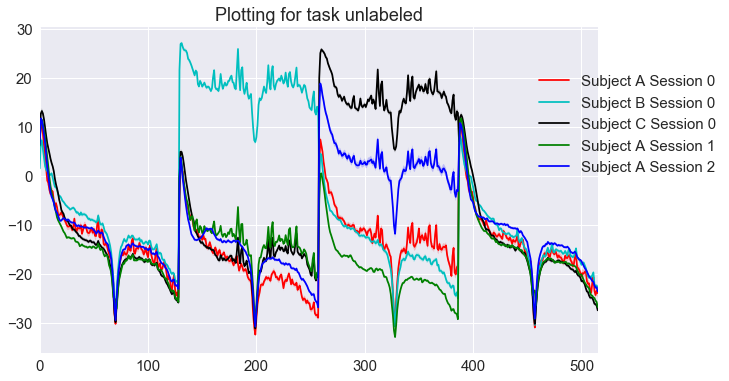

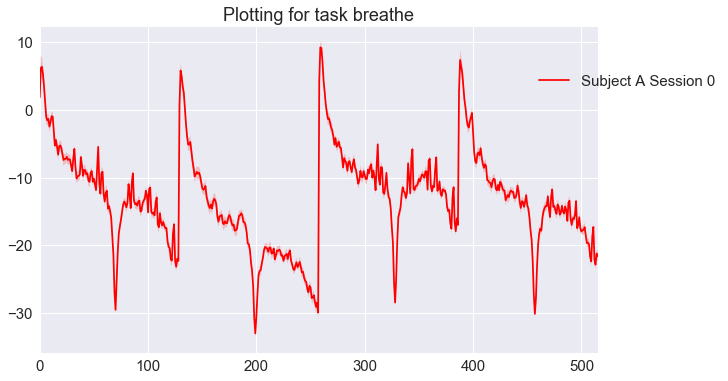

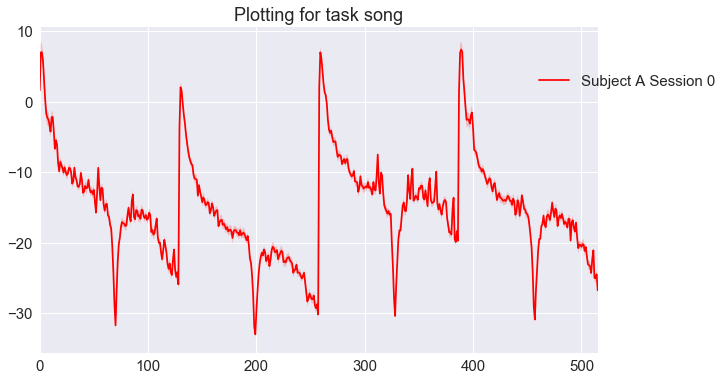

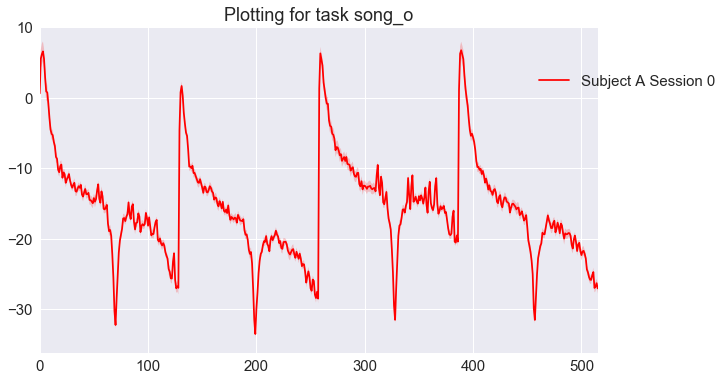

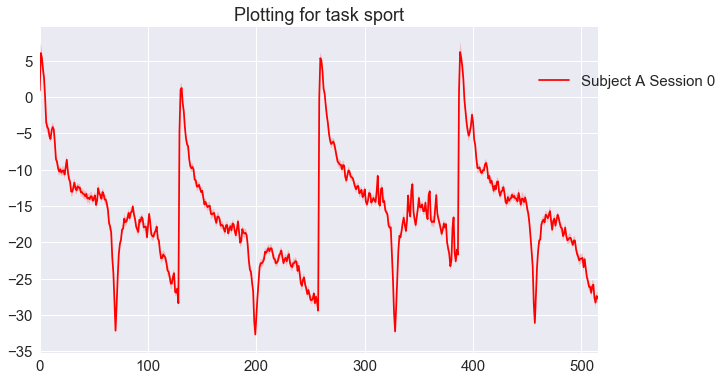

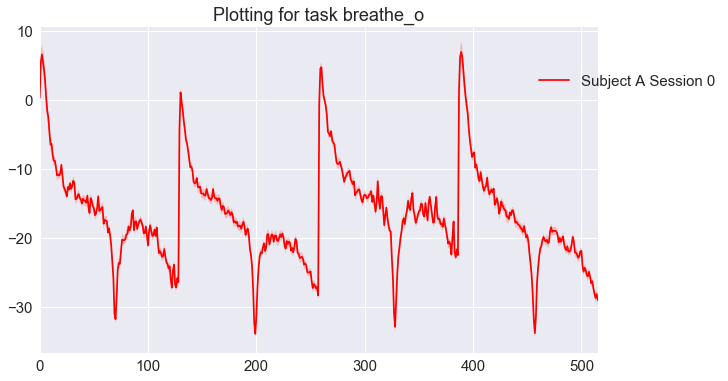

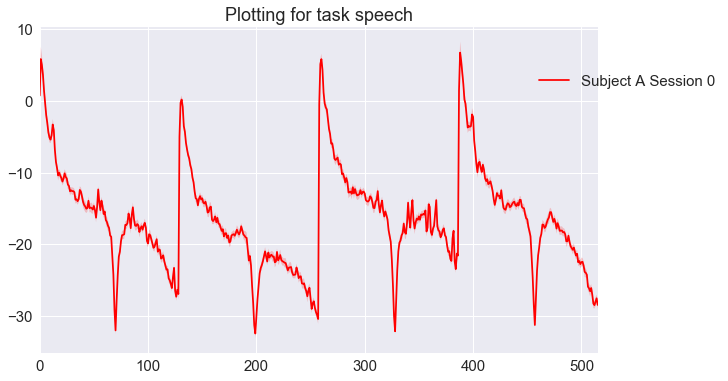

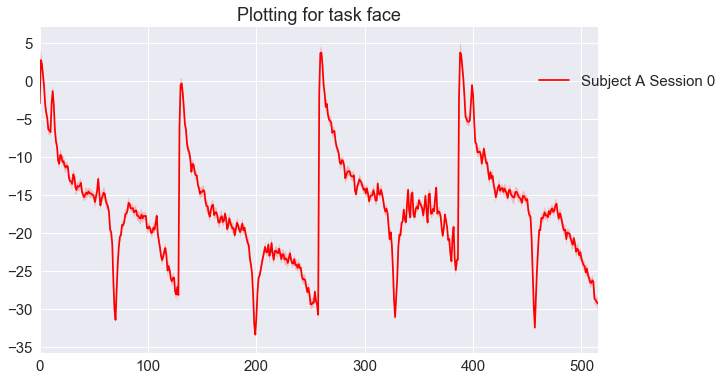

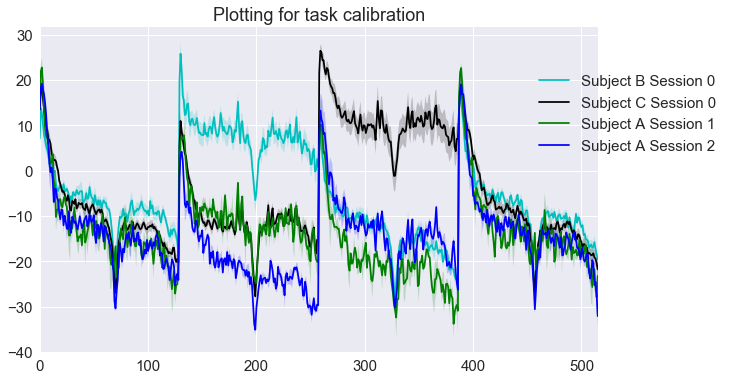

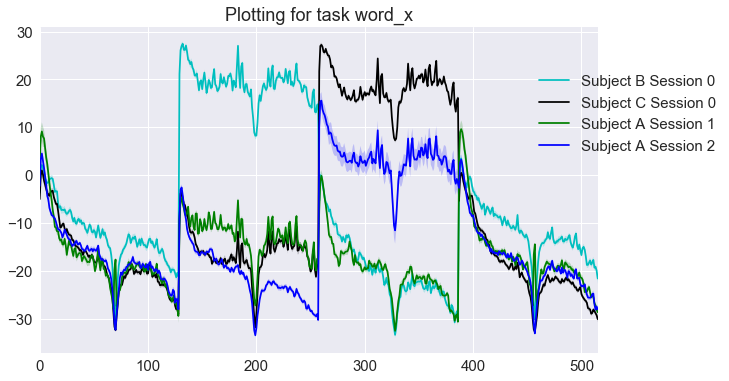

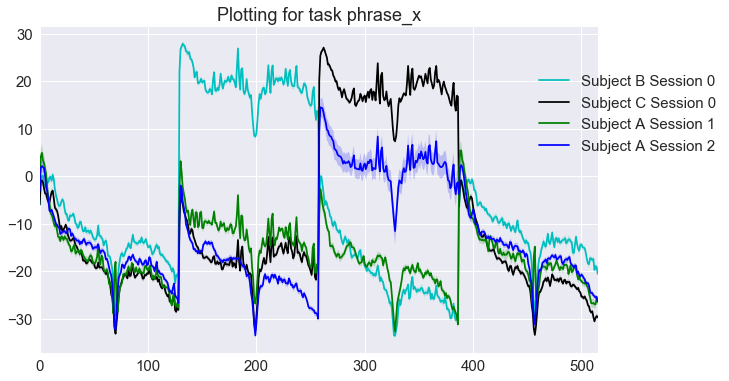

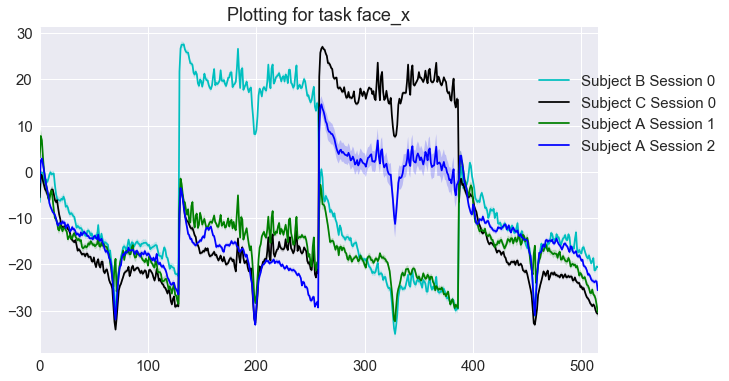

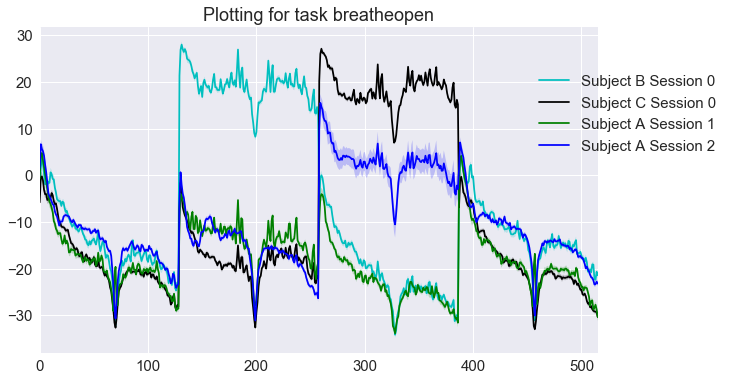

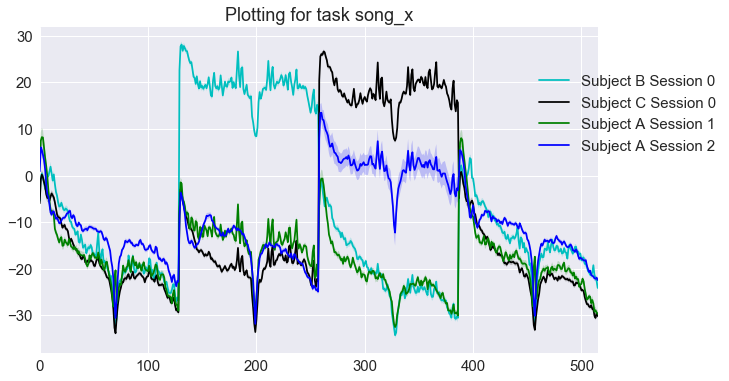

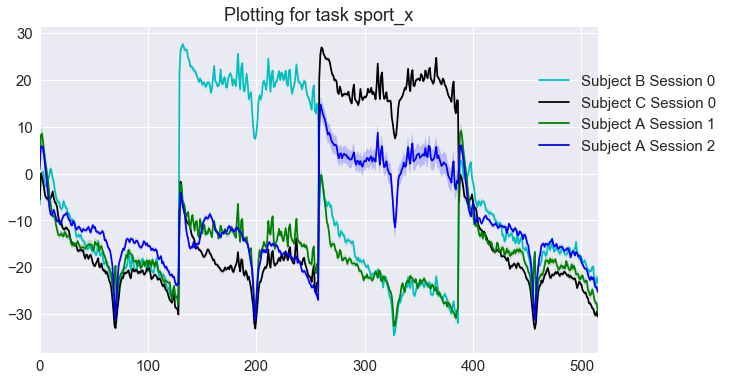

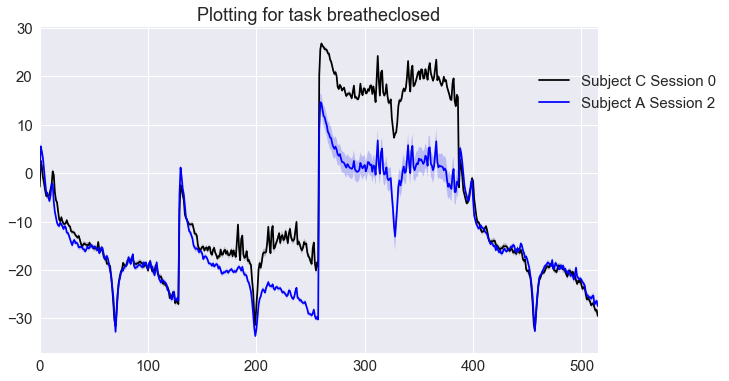

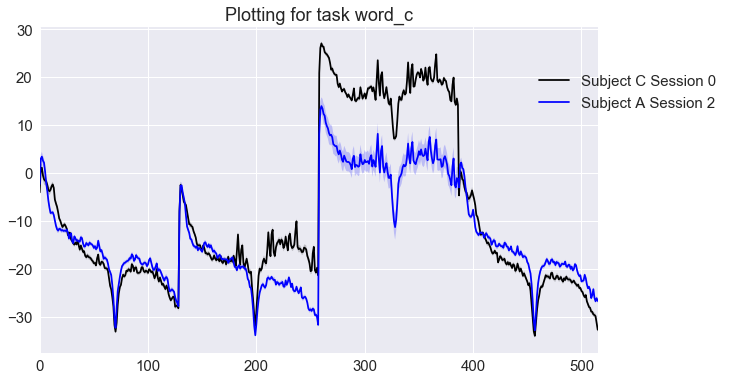

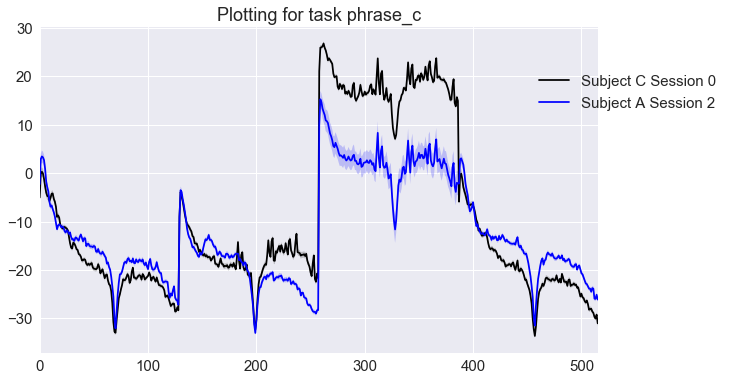

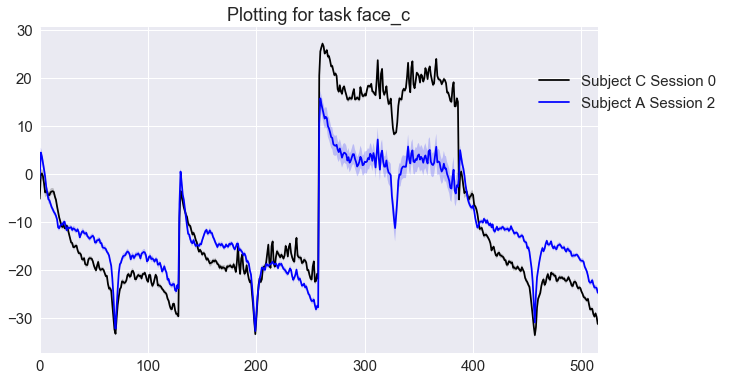

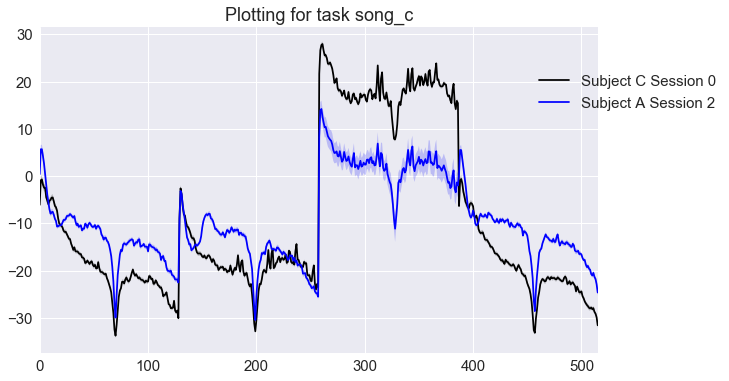

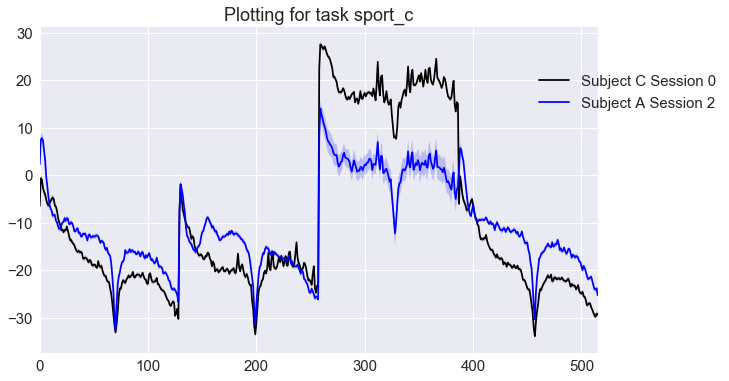

In [33]:
plot_all()

- By looking at the plots above for subject A, we can see that there seems to be significant variation in session 2 from the other two sessions for a task (when recorded across all 3 sessions). Even though, the readings follow the same general trend(overall structure of the signal) between sessions, the magnitudes across sessions vary a lot.


- For some cases the variation is so much that a session for subject A appears more similar to a session of another subject than another session for the same subject. 


- Another thing to note here is, the variation across different sessions for subject A seems like they are simply shifted across y-axis. This suggests a possibility that the variation may have been caused by some external factors or experimental conditions such as position of electrodes. 